# DQN and Double DQN with Stable-Baselines3

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

Double Q-Learning: https://paperswithcode.com/method/double-q-learning


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

## Introduction

In this notebook, we will study DQN using Stable-Baselines3 and then see how to reduce value overestimation with double DQN.

## Installation

We will install master version of SB3.

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install rl_zoo3
!pip install "stable-baselines3[extra]>=2.0.0a4"
!git clone https://github.com/DLR-RM/rl-baselines3-zoo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libice-dev libopengl-dev libsm-dev libxfont2 libxkbfile1
  libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev
  libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev libxfont2
  libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 18 not upgraded.
Ne

In [ ]:
 %load_ext tensorboard

Import DQN and evaluation helper

In [ ]:
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3.common.utils import obs_as_tensor
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

## The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py

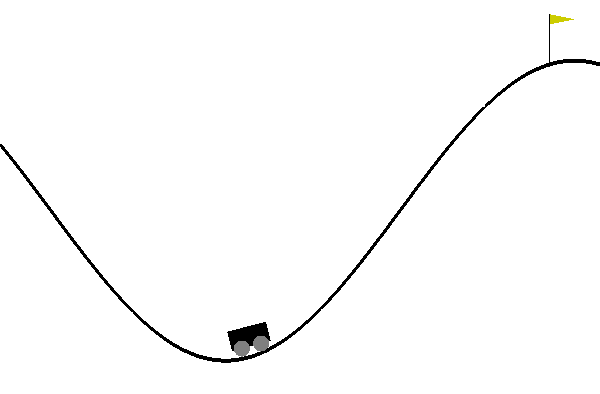


    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200



Create the environment

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

Create the model with tuned hyperparameters from the RL Zoo

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [ ]:
tensorboard_log = "/content/data/tb/"

In [ ]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.98,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate= 4e-3,
    policy_kwargs= dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=2,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the agent before training

In [ ]:
mean_reward, std_reward = evaluate_policy(
    dqn_model,
    dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


We will first train the agent until convergence and then analyse the learned q-value function.

In [ ]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to /content/data/tb/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 629      |
|    time_elapsed     | 3        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.65e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 359      |
|    time_elapsed     | 11       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss            

Evaluate after training, the mean episodic reward should have improved.

In [ ]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-118.45 +/- 22.99


In [ ]:
# Optional: Monitor training in tensorboard

# %tensorboard --logdir './data/tb/'

### Prepare video recording

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(
    env_id,
    model,
    video_length=500,
    prefix="",
    video_folder="videos/",
):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=False)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

## Visualize trained agent

In [ ]:
record_video("MountainCar-v0", dqn_model, video_length=500, prefix="dqn-mountaincar")

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [ ]:
show_videos("videos", prefix="dqn")

## Visualize Q-values

### Exercise (5 minutes): Retrieve q-values

The function will be used to retrieve the learned q-values for a given state (`observation` in the code).

The q-network from SB3 DQN can be accessed via `model.q_net` and is a PyTorch module (you can therefore call `.forward()` on it).

You need to convert the observation to a PyTorch tensor and then convert the resulting q-values to numpy array.

Note: It is recommended to use `with th.no_grad():` context to save computation and memory

In [ ]:
def get_q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    """
    Retrieve Q-values for a given observation.

    :param model: a DQN model
    :param obs: a single observation
    :return: the associated q-values for the given observation
    """
    assert model.get_env().observation_space.contains(obs), f"Invalid observation of shape {obs.shape}: {obs}"
    ### YOUR CODE HERE
    # Retrieve q-values for the given observation and convert them to numpy
    observation = obs_as_tensor(obs.reshape((-1,) + dqn_model.observation_space.shape), 'cuda')
    with th.no_grad():
      q_values = model.q_net(observation).detach().cpu().numpy().reshape(-3, )
    ### END OF YOUR CODE

    assert isinstance(q_values, np.ndarray), "The returned q_values is not a numpy array"
    assert q_values.shape == (3,), f"Wrong shape: (3,) was expected but got {q_values.shape}"

    return q_values

### Q-values for the initial state

Let's reset the environment to start a new episode:

In [ ]:
obs, _ = env.reset()

we plot the rendered environment to visualize it

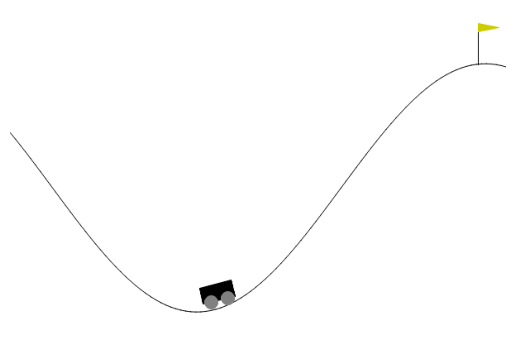

In [ ]:
plt.axis('off')
plt.imshow(env.render())

### Exercise (5 minutes): predict taken action according to q-values

Using the `get_q_values()` function, retrieve the q-values for the initial observation, print them for each action ("left", "nothing", "right") and print the action that the greedy (deterministic) policy would follow (i.e., the action with the highest q-value for that state).

In [ ]:
action_str = ["Left", "Nothing", "Right"]  # action=0 -> go left, action=1 -> do nothing, action=2 -> go right

In [ ]:
### YOUR CODE HERE
# Retrieve q-values for the initial state
# You should use `get_q_values()`

q_value_left, q_value_nothing, q_value_right  = get_q_values(dqn_model, obs)

### END OF YOUR CODE
# Print q-values for each action

print(f"Q-value of the initial state left={q_value_left:.2f} nothing={q_value_nothing:.2f} right={q_value_right:.2f}")

### YOUR CODE HERE
# Compute the action taken in the initilal state according to q-values
# when following a greedy strategy
action = np.argmax([q_value_left, q_value_nothing, q_value_right])
## END of your code here

print(f"Action taken by the greedy policy in the initial state: {action_str[action]}")

Q-value of the initial state left=-42.55 nothing=-42.65 right=-42.71
Action taken by the greedy policy in the initial state: Left


The q-value of the initial state corresponds to how much (discounted) reward the agent expects to get in this episode.

We will compare the estimated q-value to the discounted return of the episode.

In [ ]:
initial_q_value = np.max([q_value_left, q_value_nothing, q_value_right])

## Step until the end of the episode



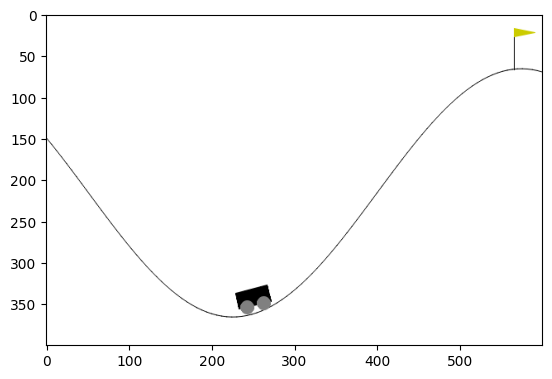

Q-value of the current state left=-42.55 nothing=-42.65 right=-42.71
Action: Left


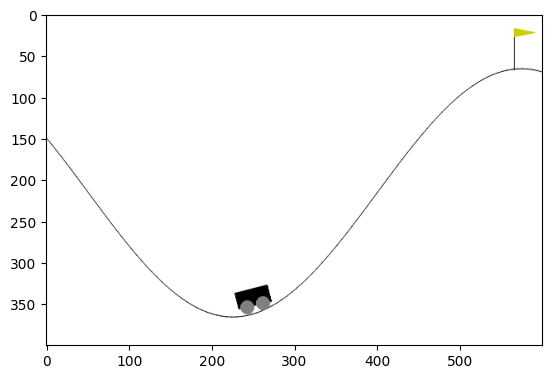

Q-value of the current state left=-42.29 nothing=-42.47 right=-42.60
Action: Left


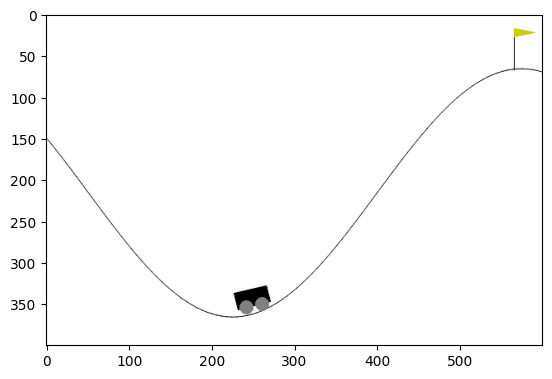

Q-value of the current state left=-42.11 nothing=-42.33 right=-42.45
Action: Left


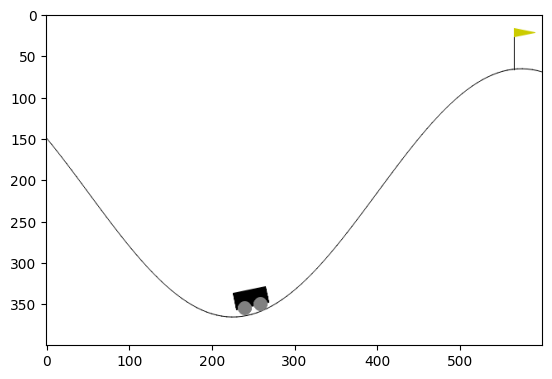

Q-value of the current state left=-42.04 nothing=-42.23 right=-42.27
Action: Left


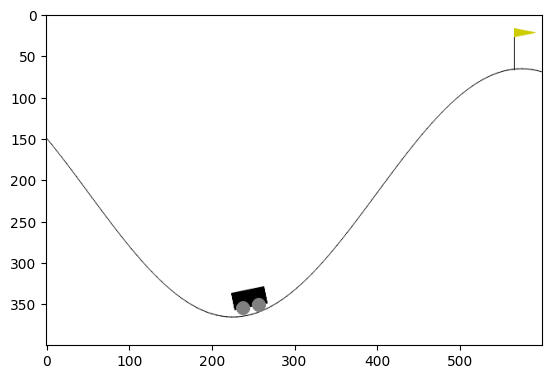

Q-value of the current state left=-42.02 nothing=-42.16 right=-42.14
Action: Left


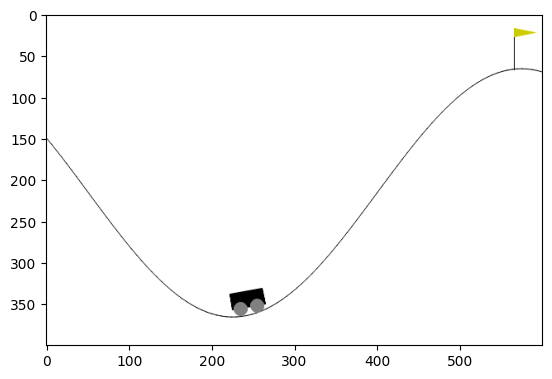

Q-value of the current state left=-42.02 nothing=-42.22 right=-42.22
Action: Left


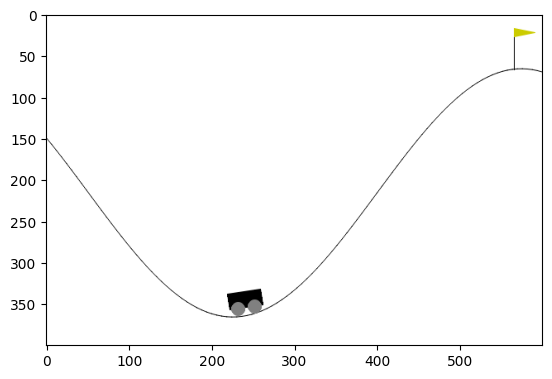

Q-value of the current state left=-42.00 nothing=-42.28 right=-42.31
Action: Left


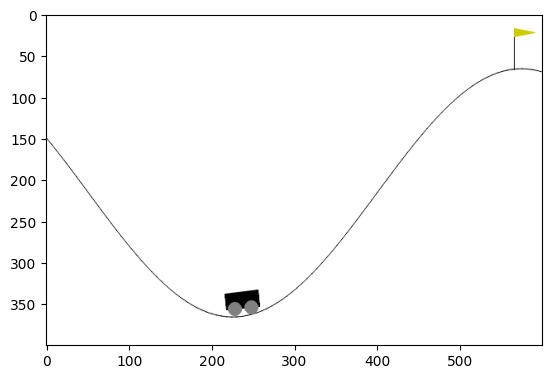

Q-value of the current state left=-42.00 nothing=-42.36 right=-42.42
Action: Left


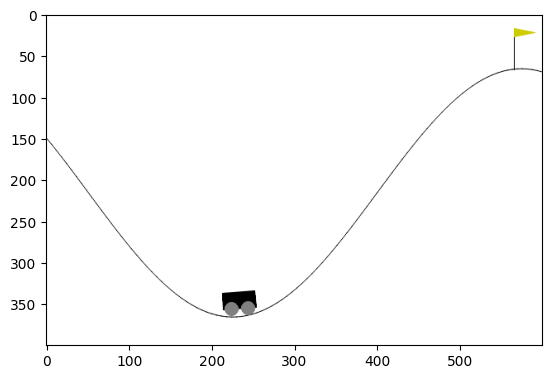

Q-value of the current state left=-41.79 nothing=-42.22 right=-42.32
Action: Left


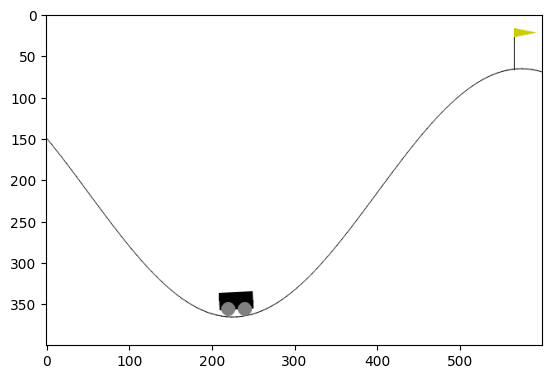

Q-value of the current state left=-41.64 nothing=-42.14 right=-42.28
Action: Left


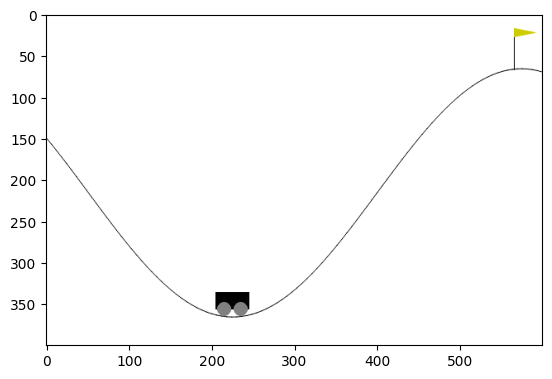

Q-value of the current state left=-41.54 nothing=-42.13 right=-42.31
Action: Left


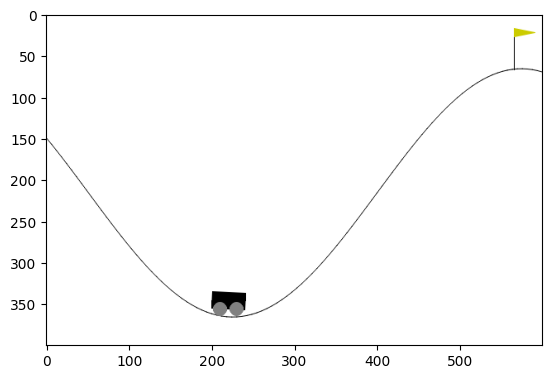

Q-value of the current state left=-41.53 nothing=-42.19 right=-42.44
Action: Left


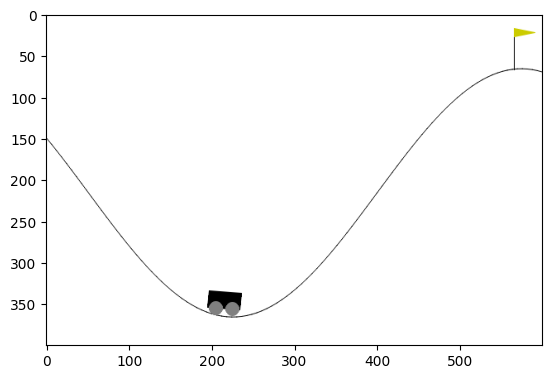

Q-value of the current state left=-41.56 nothing=-42.31 right=-42.62
Action: Left


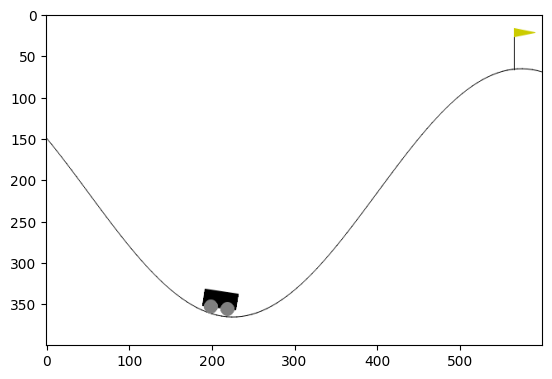

Q-value of the current state left=-41.59 nothing=-42.41 right=-42.77
Action: Left


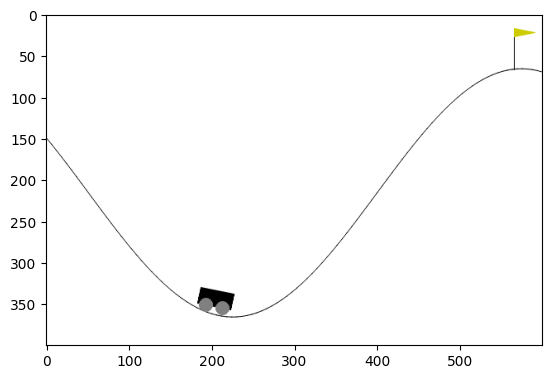

Q-value of the current state left=-40.99 nothing=-41.83 right=-42.20
Action: Left


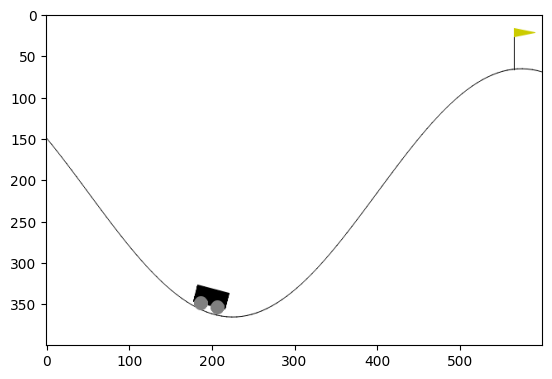

Q-value of the current state left=-40.41 nothing=-41.34 right=-41.79
Action: Left


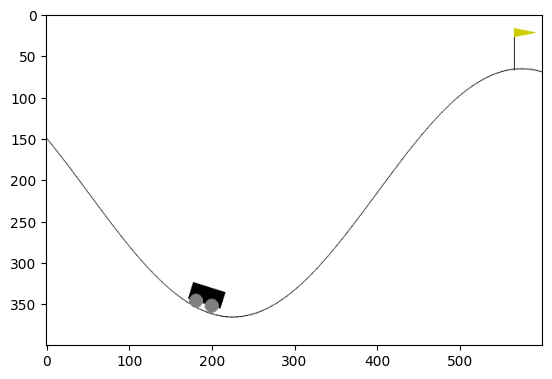

Q-value of the current state left=-40.24 nothing=-41.20 right=-41.71
Action: Left


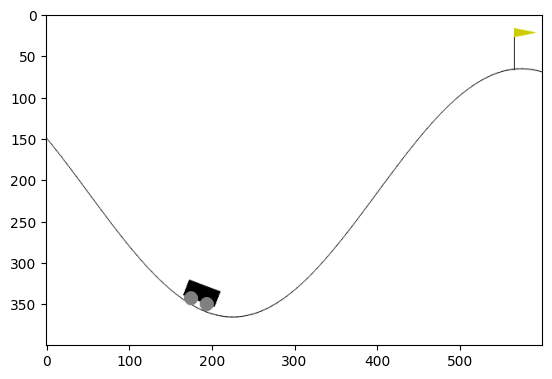

Q-value of the current state left=-40.21 nothing=-41.15 right=-41.70
Action: Left


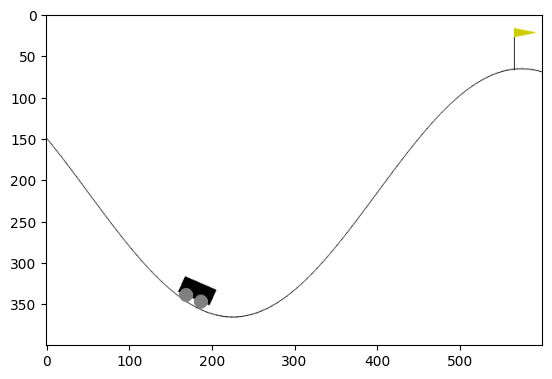

Q-value of the current state left=-40.22 nothing=-41.15 right=-41.73
Action: Left


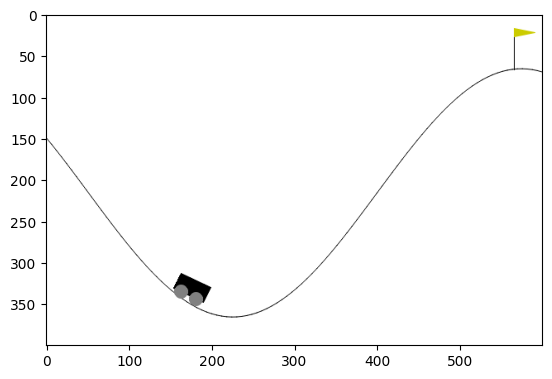

Q-value of the current state left=-40.16 nothing=-41.07 right=-41.67
Action: Left


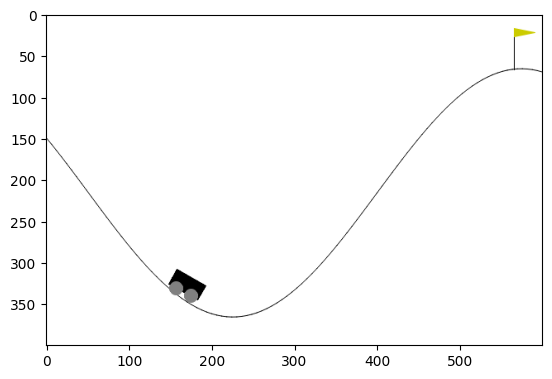

Q-value of the current state left=-40.05 nothing=-40.90 right=-41.51
Action: Left


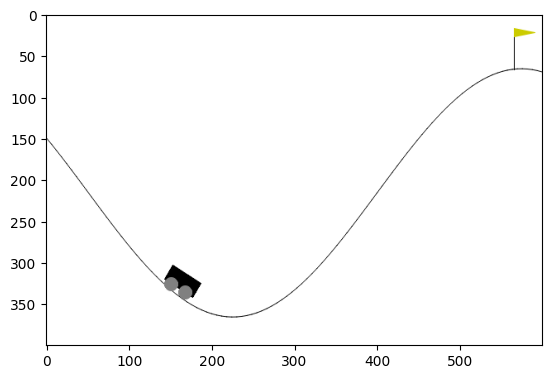

Q-value of the current state left=-39.69 nothing=-40.40 right=-40.95
Action: Left


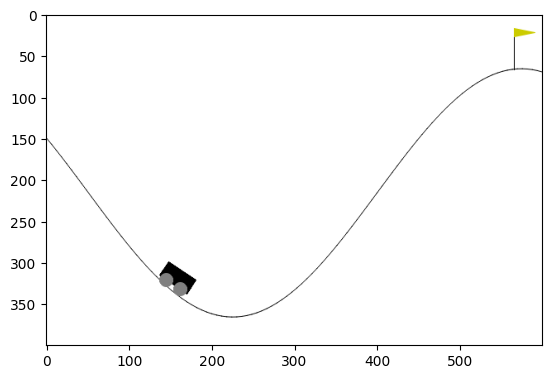

Q-value of the current state left=-39.42 nothing=-40.00 right=-40.49
Action: Left


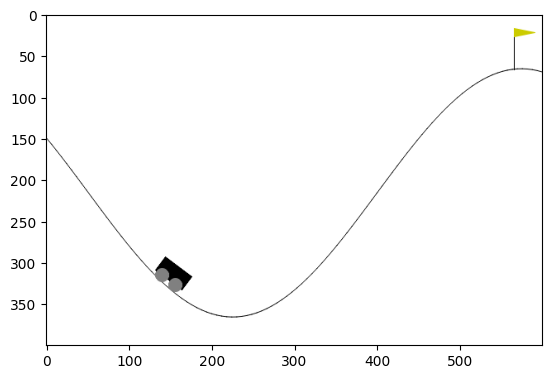

Q-value of the current state left=-39.24 nothing=-39.68 right=-40.12
Action: Left


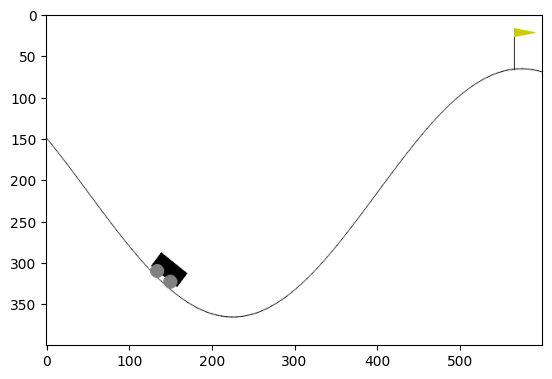

Q-value of the current state left=-38.66 nothing=-38.99 right=-39.37
Action: Left


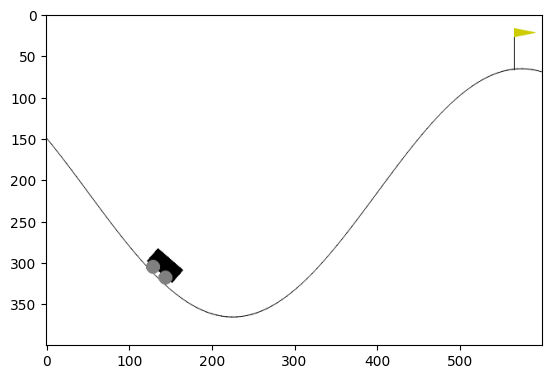

Q-value of the current state left=-38.28 nothing=-38.51 right=-38.83
Action: Left


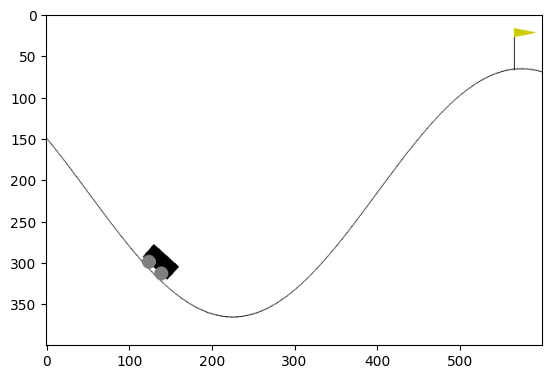

Q-value of the current state left=-37.96 nothing=-38.10 right=-38.36
Action: Left


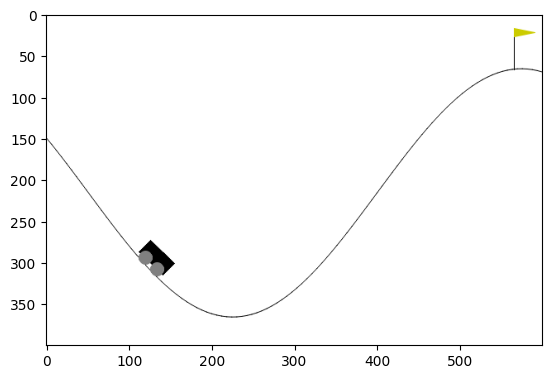

Q-value of the current state left=-37.73 nothing=-37.79 right=-38.00
Action: Left


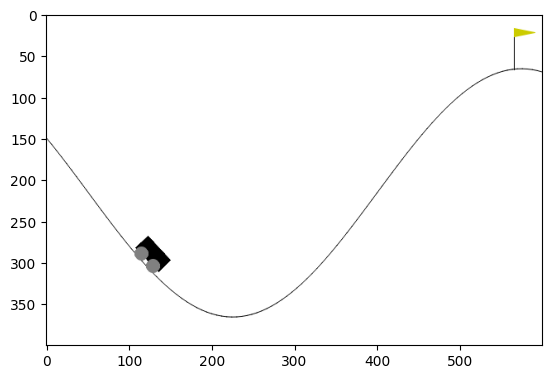

Q-value of the current state left=-37.60 nothing=-37.62 right=-37.80
Action: Left


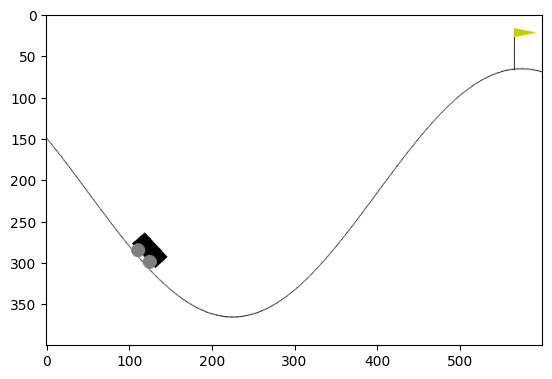

Q-value of the current state left=-37.46 nothing=-37.44 right=-37.59
Action: Nothing


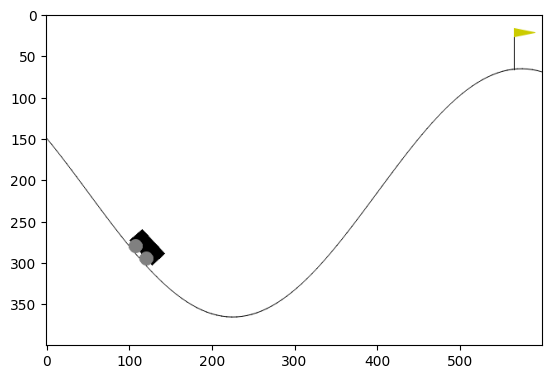

Q-value of the current state left=-37.78 nothing=-37.66 right=-37.74
Action: Nothing


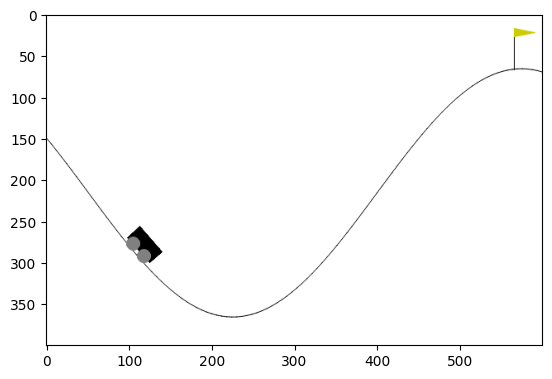

Q-value of the current state left=-37.60 nothing=-37.39 right=-37.39
Action: Right


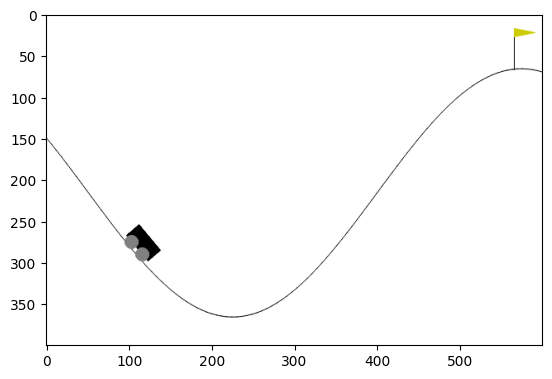

Q-value of the current state left=-37.36 nothing=-37.10 right=-37.01
Action: Right


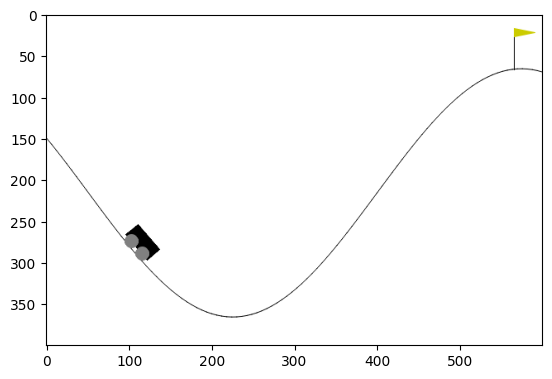

Q-value of the current state left=-36.68 nothing=-36.38 right=-36.22
Action: Right


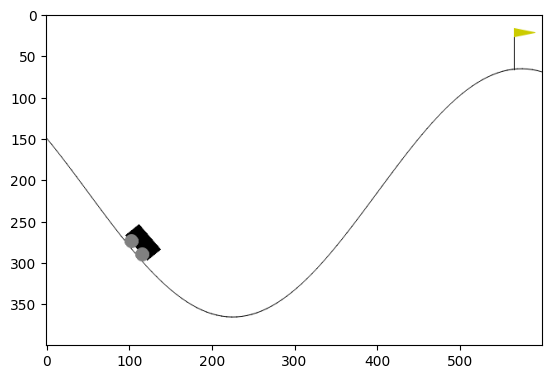

Q-value of the current state left=-36.33 nothing=-36.00 right=-35.76
Action: Right


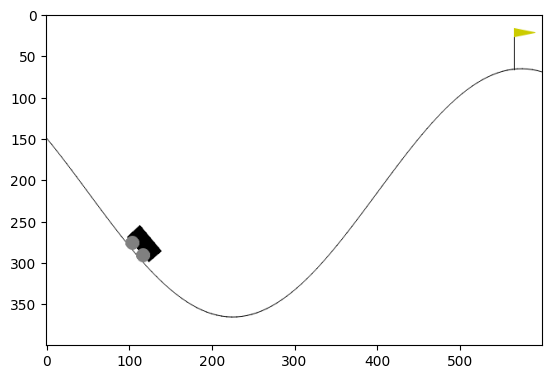

Q-value of the current state left=-36.13 nothing=-35.75 right=-35.42
Action: Right


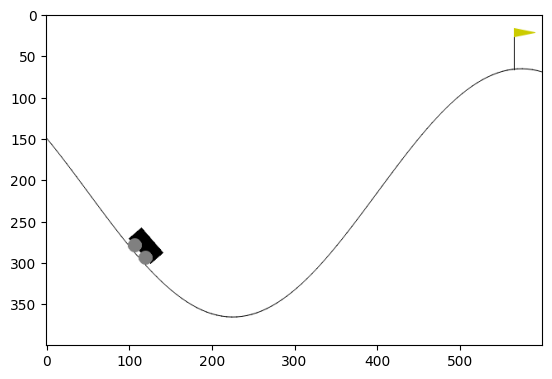

Q-value of the current state left=-36.13 nothing=-35.68 right=-35.23
Action: Right


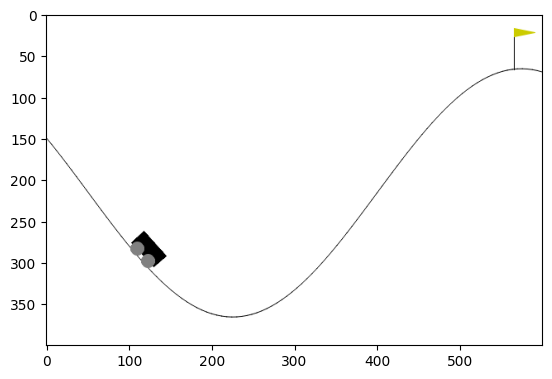

Q-value of the current state left=-36.47 nothing=-35.76 right=-35.04
Action: Right


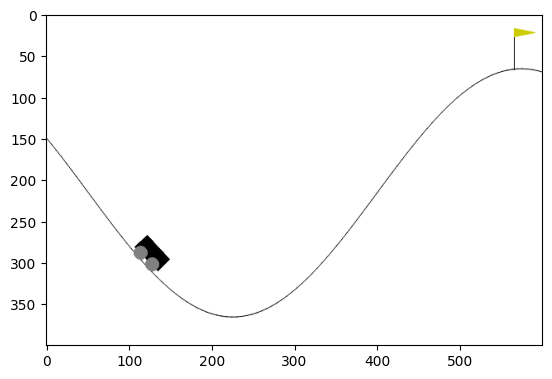

Q-value of the current state left=-37.90 nothing=-36.70 right=-35.59
Action: Right


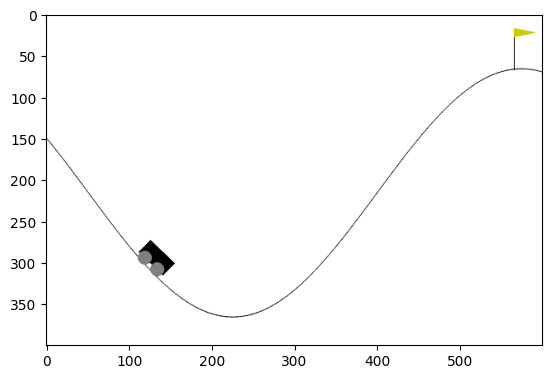

Q-value of the current state left=-38.74 nothing=-37.37 right=-36.19
Action: Right


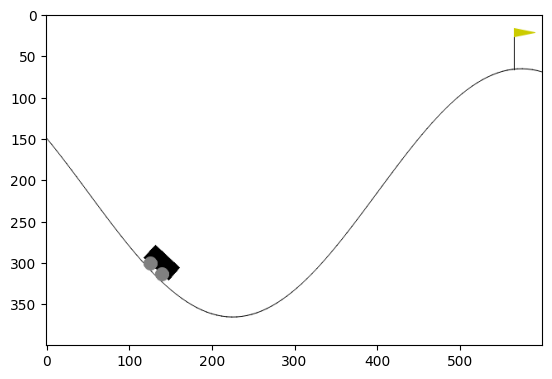

Q-value of the current state left=-39.53 nothing=-38.01 right=-36.79
Action: Right


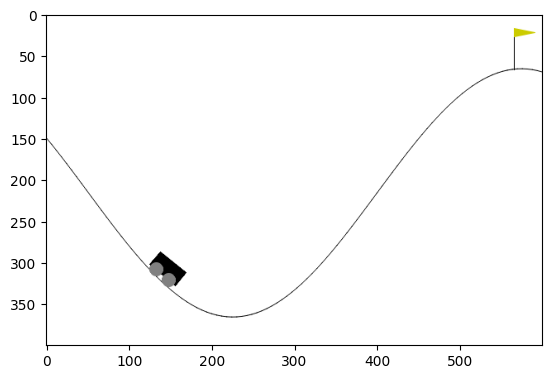

Q-value of the current state left=-40.37 nothing=-38.98 right=-37.91
Action: Right


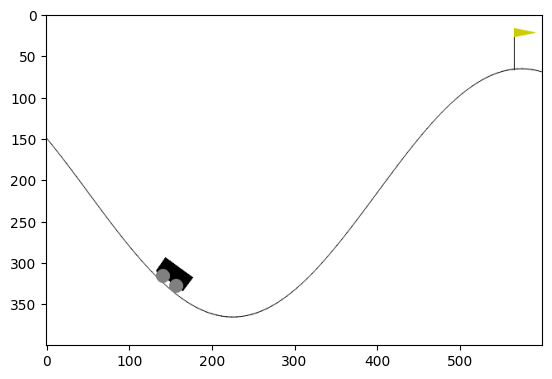

Q-value of the current state left=-39.14 nothing=-37.39 right=-36.04
Action: Right


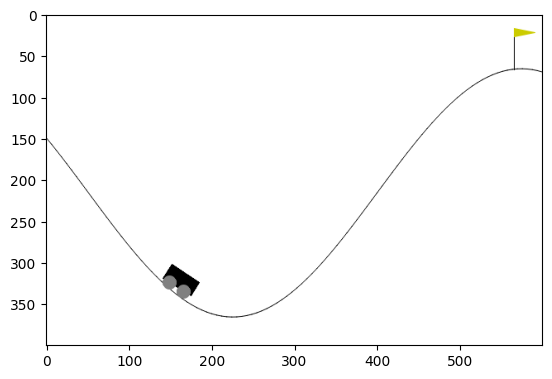

Q-value of the current state left=-37.88 nothing=-35.99 right=-34.48
Action: Right


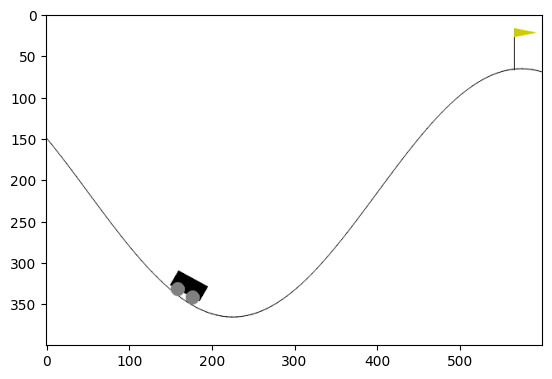

Q-value of the current state left=-36.81 nothing=-34.86 right=-33.25
Action: Right


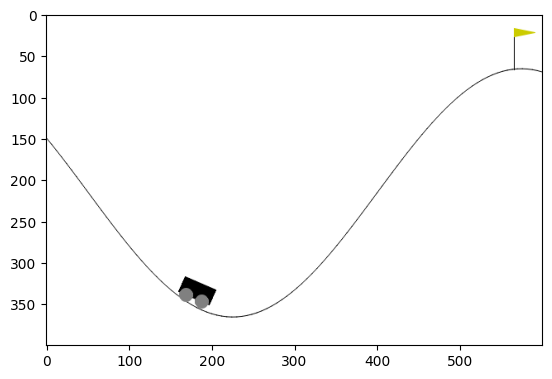

Q-value of the current state left=-36.01 nothing=-33.99 right=-32.31
Action: Right


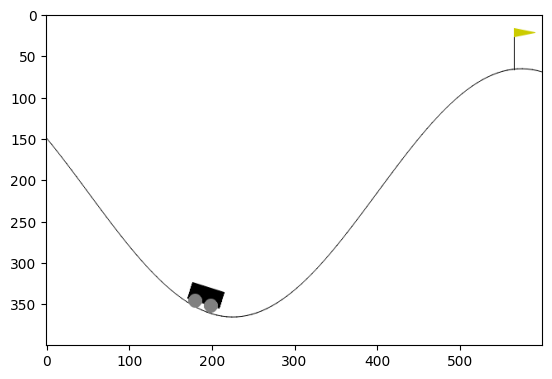

Q-value of the current state left=-35.58 nothing=-33.48 right=-31.72
Action: Right


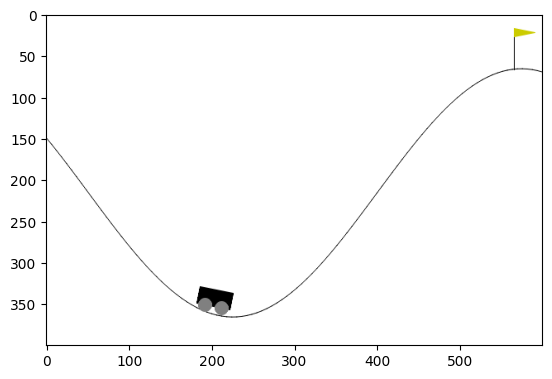

Q-value of the current state left=-36.30 nothing=-34.17 right=-32.12
Action: Right


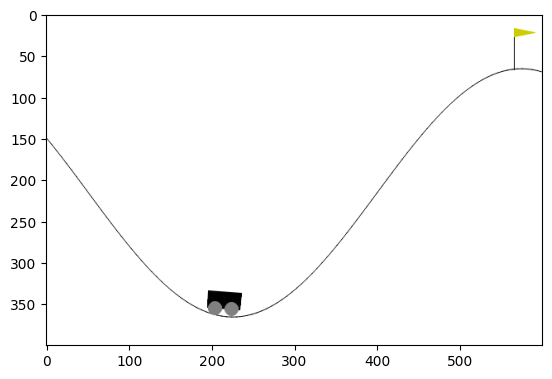

Q-value of the current state left=-36.57 nothing=-34.47 right=-32.30
Action: Right


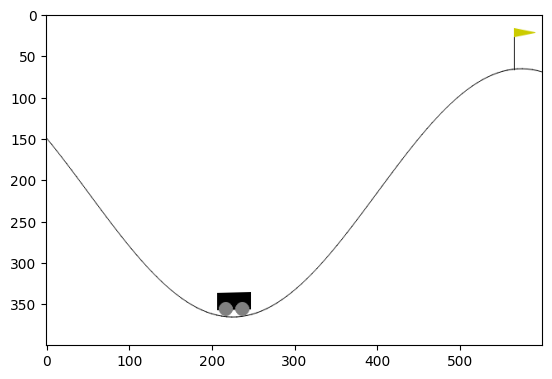

Q-value of the current state left=-34.91 nothing=-32.77 right=-30.47
Action: Right


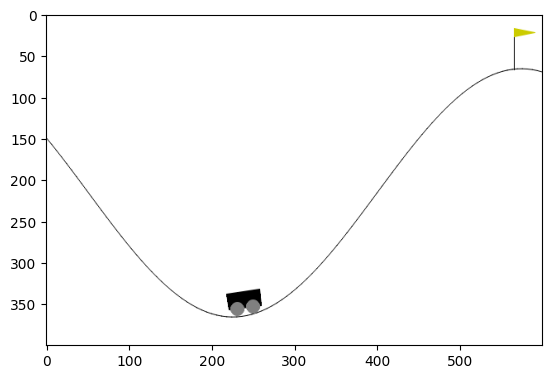

Q-value of the current state left=-33.61 nothing=-31.38 right=-29.04
Action: Right


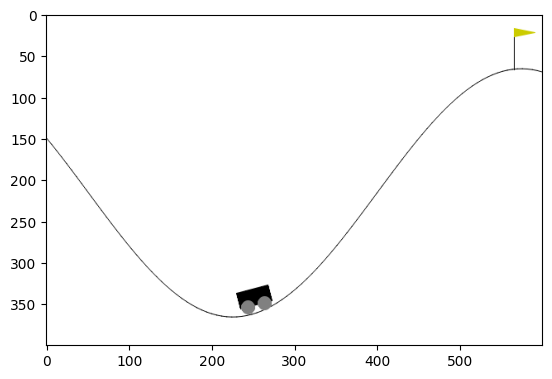

Q-value of the current state left=-31.95 nothing=-29.90 right=-27.70
Action: Right


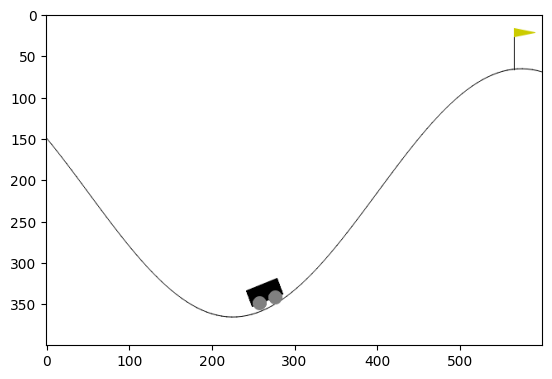

Q-value of the current state left=-30.96 nothing=-29.21 right=-27.28
Action: Right


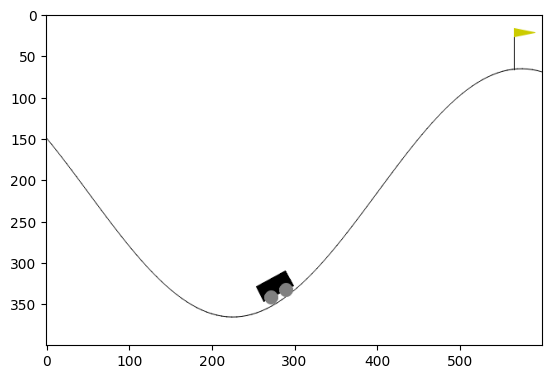

Q-value of the current state left=-30.39 nothing=-28.89 right=-27.19
Action: Right


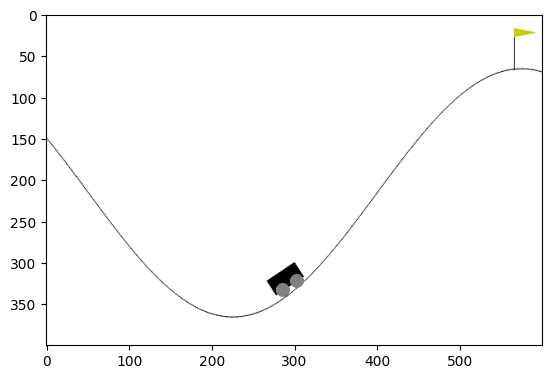

Q-value of the current state left=-29.92 nothing=-28.52 right=-26.85
Action: Right


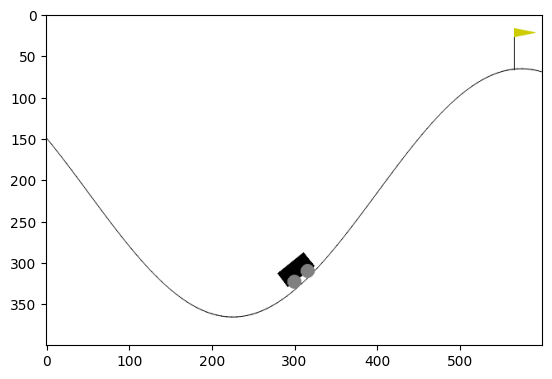

Q-value of the current state left=-30.18 nothing=-28.97 right=-27.23
Action: Right


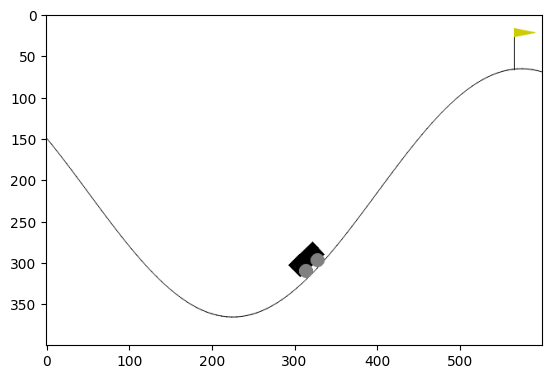

Q-value of the current state left=-30.78 nothing=-29.78 right=-27.95
Action: Right


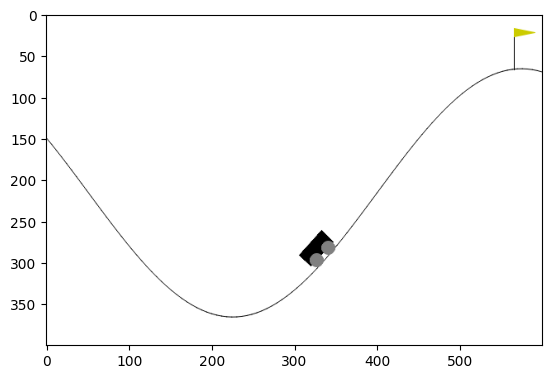

Q-value of the current state left=-31.01 nothing=-30.14 right=-28.28
Action: Right


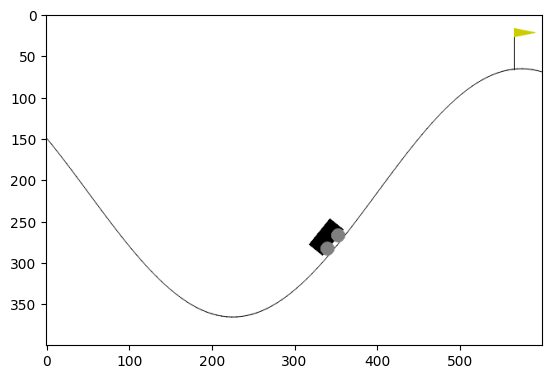

Q-value of the current state left=-30.71 nothing=-29.87 right=-28.04
Action: Right


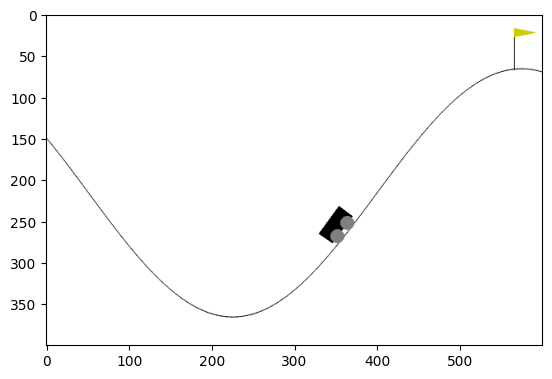

Q-value of the current state left=-30.67 nothing=-29.94 right=-28.22
Action: Right


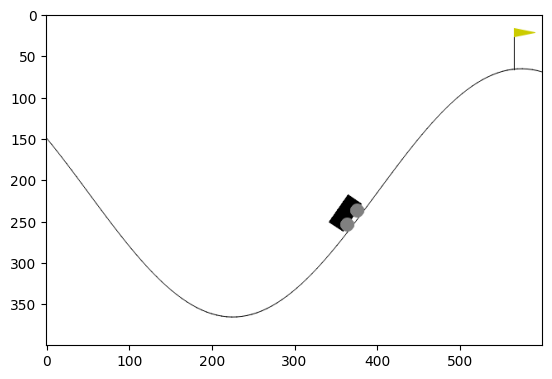

Q-value of the current state left=-30.97 nothing=-30.39 right=-28.76
Action: Right


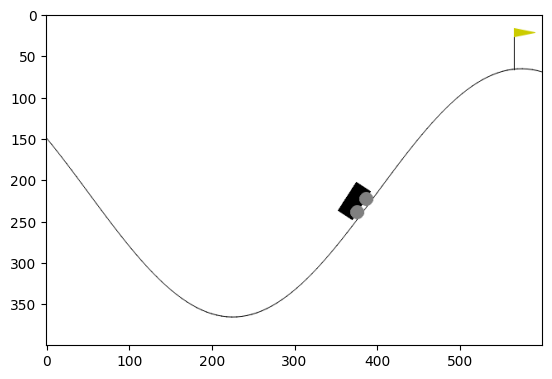

Q-value of the current state left=-28.10 nothing=-27.65 right=-26.43
Action: Right


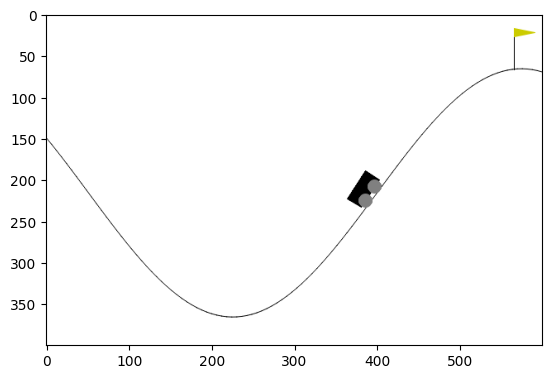

Q-value of the current state left=-25.61 nothing=-25.28 right=-24.26
Action: Right


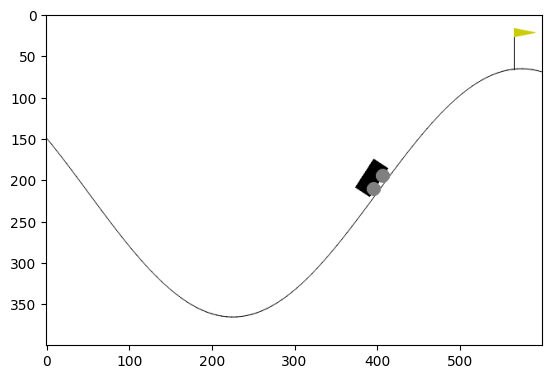

Q-value of the current state left=-23.44 nothing=-23.24 right=-22.42
Action: Right


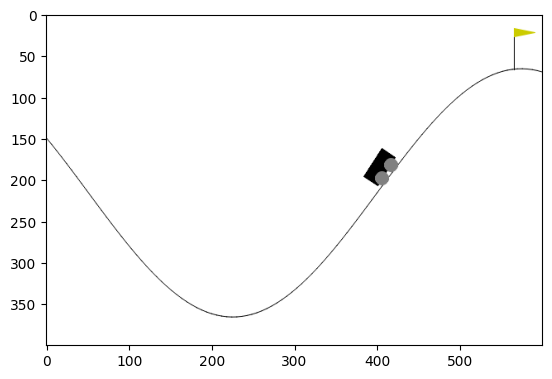

Q-value of the current state left=-22.94 nothing=-22.91 right=-22.27
Action: Right


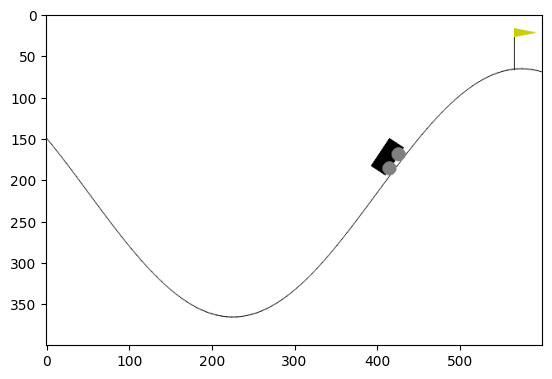

Q-value of the current state left=-22.54 nothing=-22.67 right=-22.21
Action: Right


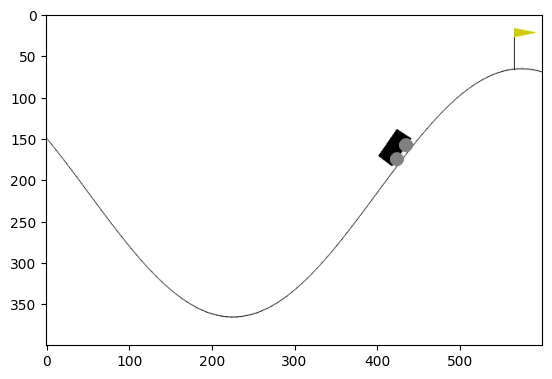

Q-value of the current state left=-22.37 nothing=-22.47 right=-22.01
Action: Right


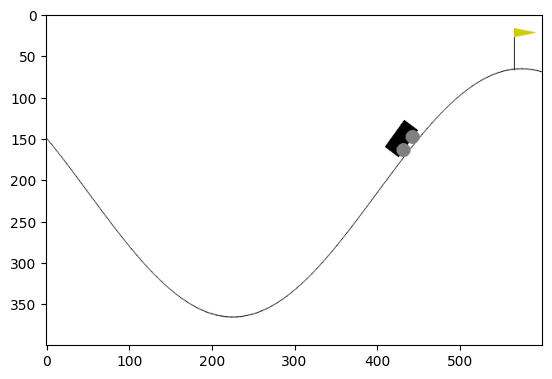

Q-value of the current state left=-22.28 nothing=-22.32 right=-21.81
Action: Right


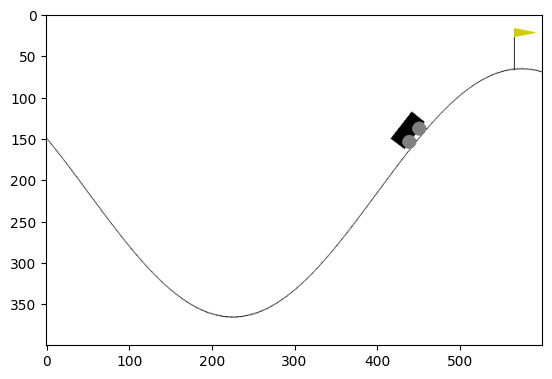

Q-value of the current state left=-22.22 nothing=-22.21 right=-21.65
Action: Right


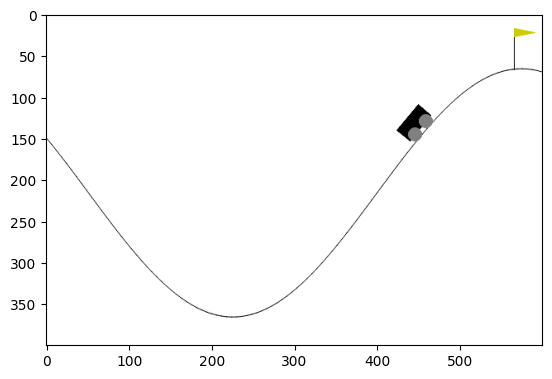

Q-value of the current state left=-22.18 nothing=-22.11 right=-21.51
Action: Right


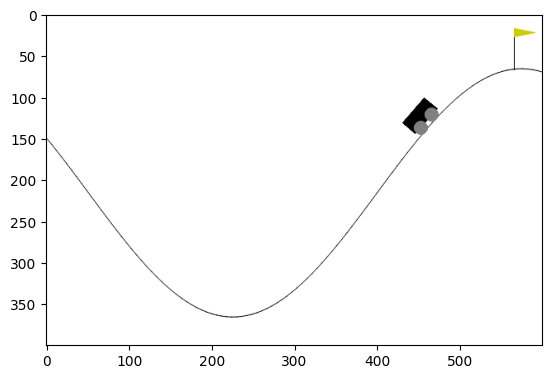

Q-value of the current state left=-22.18 nothing=-22.05 right=-21.42
Action: Right


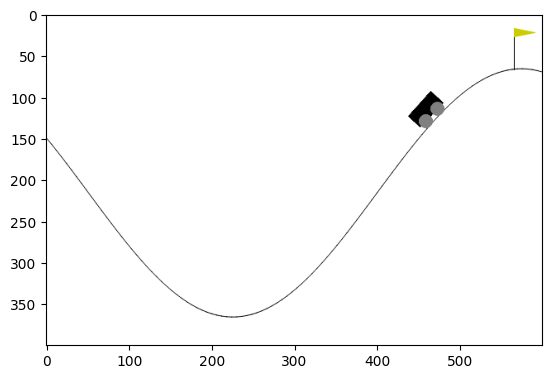

Q-value of the current state left=-22.28 nothing=-22.07 right=-21.42
Action: Right


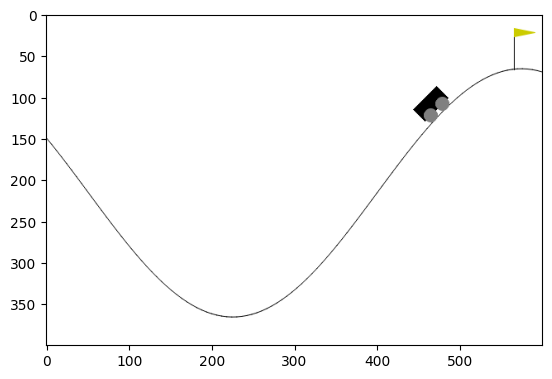

Q-value of the current state left=-22.33 nothing=-22.05 right=-21.38
Action: Right


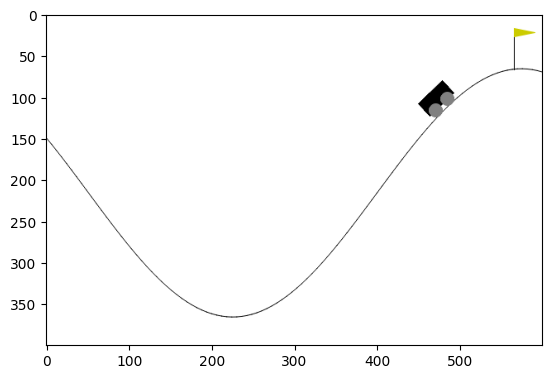

Q-value of the current state left=-22.33 nothing=-21.97 right=-21.28
Action: Right


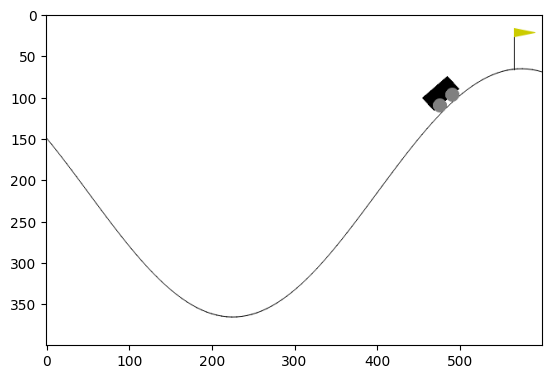

Q-value of the current state left=-22.29 nothing=-21.85 right=-21.14
Action: Right


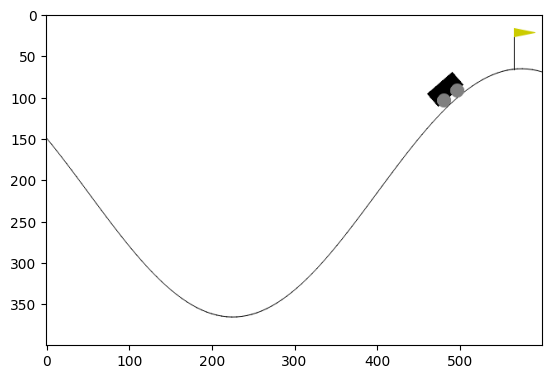

Q-value of the current state left=-22.20 nothing=-21.68 right=-20.95
Action: Right


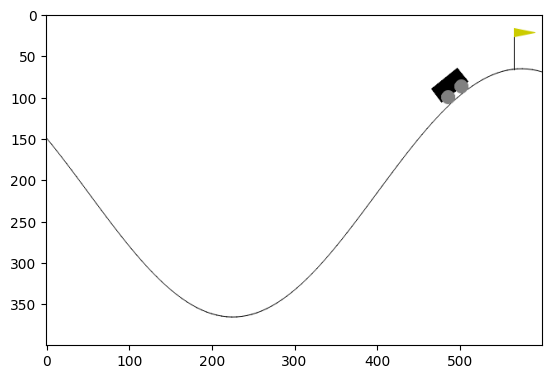

Q-value of the current state left=-22.06 nothing=-21.45 right=-20.70
Action: Right


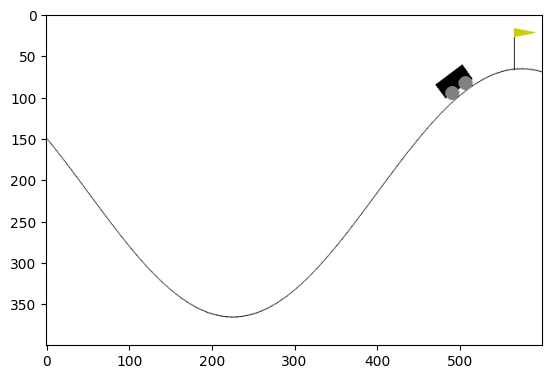

Q-value of the current state left=-21.85 nothing=-21.16 right=-20.39
Action: Right


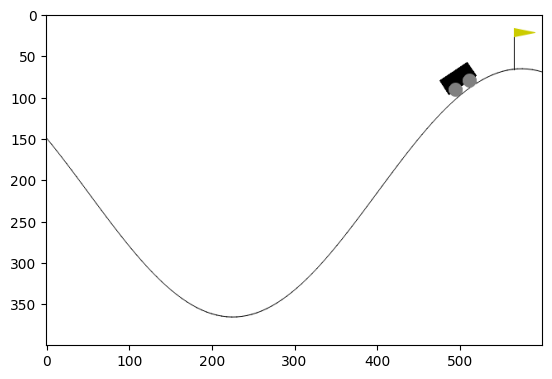

Q-value of the current state left=-21.58 nothing=-20.80 right=-20.01
Action: Right


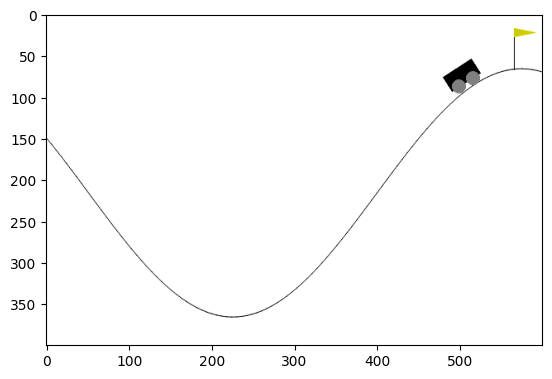

Q-value of the current state left=-21.23 nothing=-20.37 right=-19.55
Action: Right


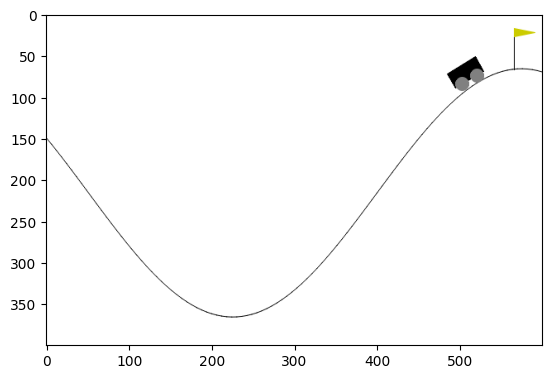

Q-value of the current state left=-20.83 nothing=-19.90 right=-19.06
Action: Right


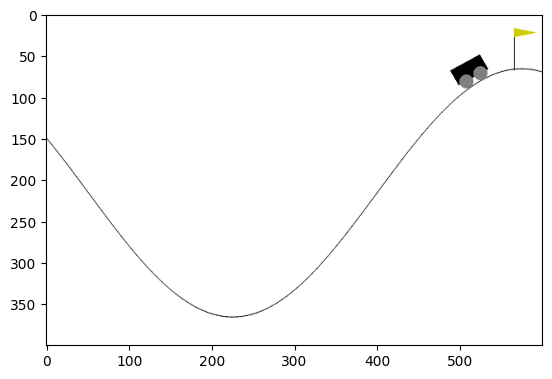

Q-value of the current state left=-20.49 nothing=-19.53 right=-18.65
Action: Right


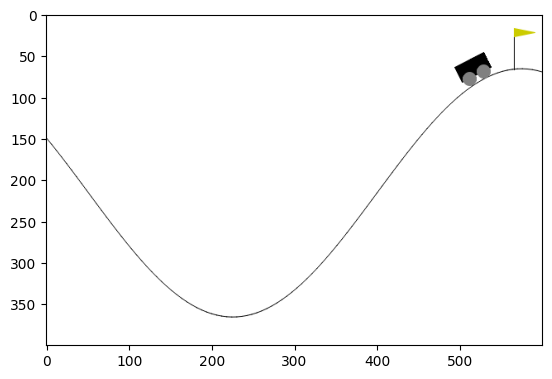

Q-value of the current state left=-20.06 nothing=-19.06 right=-18.16
Action: Right


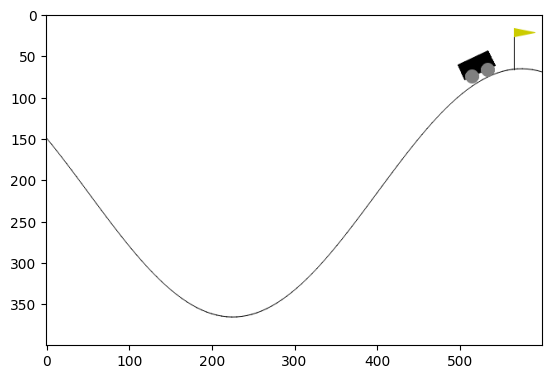

Q-value of the current state left=-19.54 nothing=-18.51 right=-17.56
Action: Right


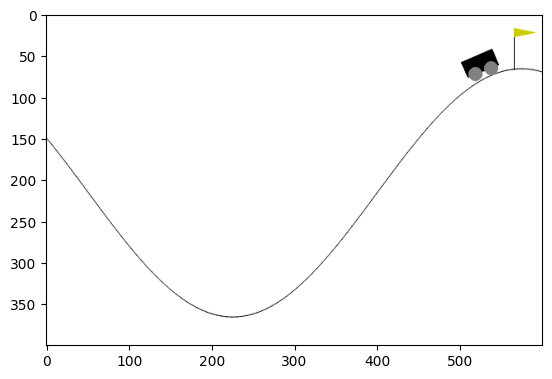

Q-value of the current state left=-18.93 nothing=-17.86 right=-16.87
Action: Right


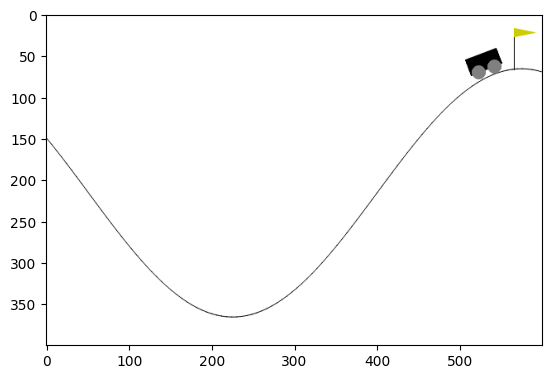

Q-value of the current state left=-18.22 nothing=-17.11 right=-16.07
Action: Right


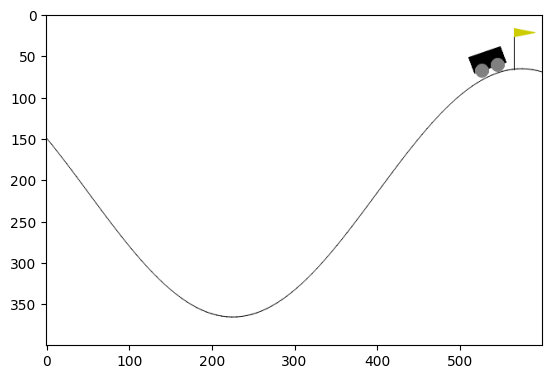

Q-value of the current state left=-17.41 nothing=-16.24 right=-15.16
Action: Right


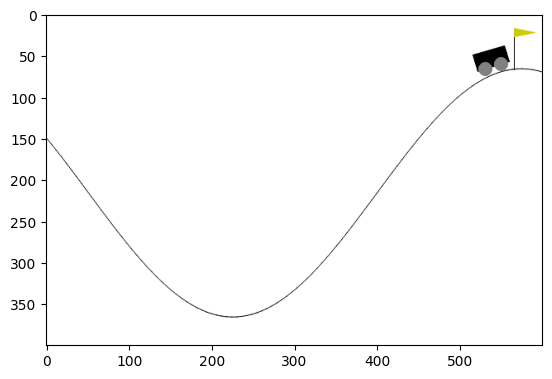

Q-value of the current state left=-16.55 nothing=-15.33 right=-14.19
Action: Right


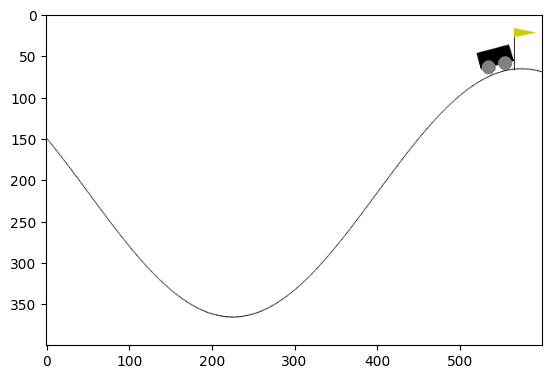

Q-value of the current state left=-15.66 nothing=-14.42 right=-13.27
Action: Right


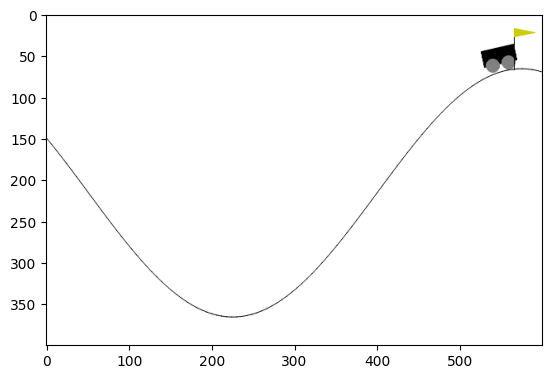

Q-value of the current state left=-14.68 nothing=-13.46 right=-12.33
Action: Right


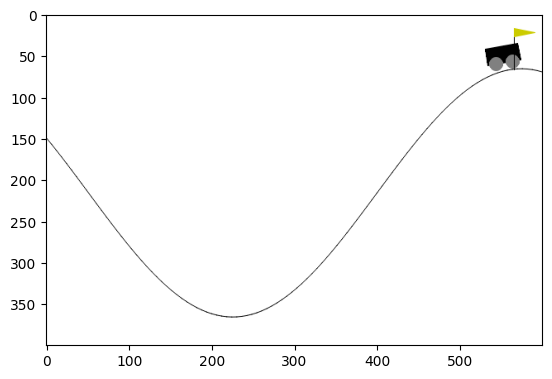

Q-value of the current state left=-13.67 nothing=-12.46 right=-11.37
Action: Right


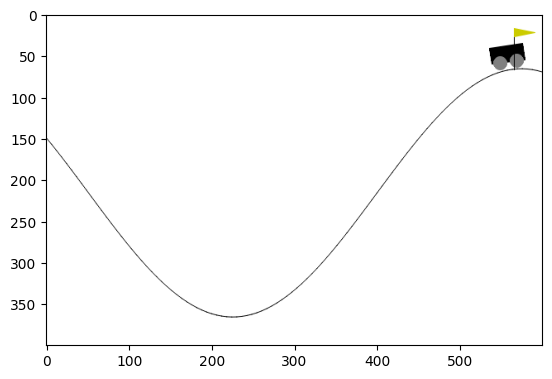

Q-value of the current state left=-13.02 nothing=-11.83 right=-10.78
Action: Right


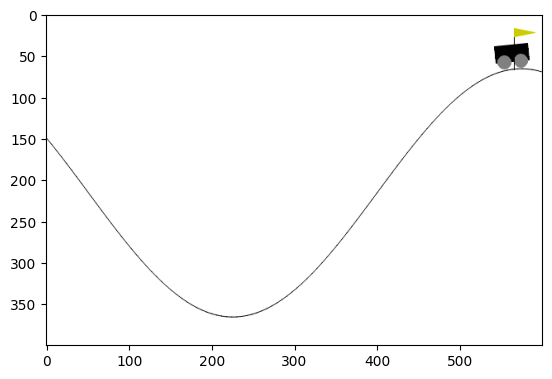

Q-value of the current state left=-12.56 nothing=-11.38 right=-10.38
Action: Right


In [ ]:
episode_rewards = []
done = False
i = 0

while not done:
    i += 1

    # Display current state
    plt.imshow(env.render())
    plt.show()

    # Retrieve q-value
    q_values = get_q_values(dqn_model, obs)

    # Take greedy-action
    action, _ = dqn_model.predict(obs, deterministic=True)

    print(f"Q-value of the current state left={q_values[0]:.2f} nothing={q_values[1]:.2f} right={q_values[2]:.2f}")
    print(f"Action: {action_str[action]}")

    obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

    episode_rewards.append(reward)


### Exercise (3 minutes): compare estimated initial q-value with actual discounted return

Compute the discounted return (sum of discounted reward) of the episode and compare it to the initial estimated q-value.

Note: You will need to use the discount factor `dqn_model.gamma`

In [ ]:
sum_discounted_rewards = 0

### YOUR CODE HERE
# Compute the sum of discounted reward for the last episode
# using `episode_rewards` list and `dqn_model.gamma` discount factor

sum_discounted_rewards = 0
for i, reward in enumerate(episode_rewards):
    sum_discounted_rewards += reward * (dqn_model.gamma ** i)
### END OF YOUR CODE

print(f"Sum discounted rewards: {sum_discounted_rewards:.2f}, initial q-value {initial_q_value:.2f}")

Sum discounted rewards: -42.36, initial q-value -42.55


## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [ ]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)

                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = th.argmax(next_q_values_online, dim=1, keepdim=True)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online)
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)

            ### END OF YOUR CODE

            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [ ]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset()[0] for _ in range(n_samples)])

    def _on_training_start(self) -> None:
        # Create overestimation
        obs = th.tensor(self.start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [ ]:
dqn_model = DQN(
    "MlpPolicy",
    "MountainCar-v0",
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=5000,
    learning_starts=1000,
    buffer_size=25000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=102,
)

Using cuda device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Define the callback

In [ ]:
monitor_dqn_value_cb = MonitorQValueCallback()

In [ ]:
dqn_model.learn(total_timesteps=int(4e4), callback=monitor_dqn_value_cb)

Logging to /content/data/tb/DQN_5
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 307      |
|    time_elapsed     | 2        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 455      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.000411 |
|    n_updates        | 296      |
----------------------------------
----------------------------------
| rollout/           

### Double DQN

In [ ]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.98,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cuda device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
monitor_double_q_value_cb = MonitorQValueCallback()

In [ ]:
double_q.learn(int(4e4), log_interval=10, callback=monitor_double_q_value_cb)

Logging to /content/data/tb/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 631      |
|    time_elapsed     | 3        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.0527   |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 540      |
|    time_elapsed     | 7        |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss            

### Evolution of the max q-value for start states over time

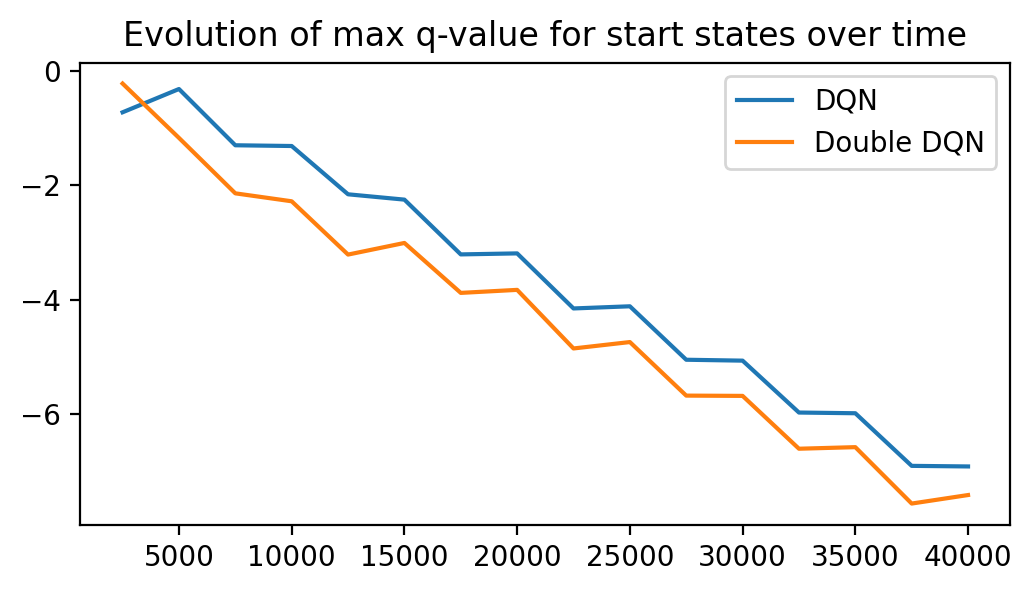

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()